In [1]:
### Import modules
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cmocean.cm as cmo
from os.path import exists

font = {'size'   : 8}
plt.rc('font', **font)

## simulation constants
nu = 2e-6
f0=1.37e-4
T=2*np.pi/f0
alpha = 3.8e-5
beta = 7.8e-4
Pr = 14
Sc = 1500
kt=nu/Pr
ks=nu/Sc


## Other
syr = 60*60*24*365
sH = 60*60
k=0.41

In [2]:
if exists('./transfer_coeffs.nc'):
    d1 = xr.open_dataset('./transfer_coeffs.nc')
    print('already exists, load data')
else:
    ### Load data - steady melting experiments
    headstr = '../../Documents/2022/Oceanography/ice-ocean-2022/mmr0-ISOBL_model_out/'
    tailstr = ['u07_T005','u14_T005','u28_T005',
               'u07_T01','u14_T01','u28_T01',
               'u07_T05','u14_T05','u28_T05']

    ## simulation parameters
    U0 = [0.007, 0.014,0.028,0.007, 0.014,0.028,0.007, 0.014,0.028];
    nf = [1,1,2,1,1,2,1,1,2]
    t_end = [3,3,2,3,3,2,3,3,2] # length of sim in inertial periods

    ###
    GT_arr = np.empty(len(U0))
    GT_arr[:] =  np.nan
    GS_arr = np.empty(len(U0))
    GS_arr[:] =  np.nan
    Lp_arr = np.empty(len(U0))
    Lp_arr[:] =  np.nan
    Cd_arr = np.empty(len(U0))
    Cd_arr[:] =  np.nan

    for ii in range(len(U0)): 

        fname = '%s/ISOBL_model_output.nc'% (headstr + tailstr[ii])
        ds = xr.open_dataset(fname)
        # _, index = np.unique(tmp['y'], return_index=True)
        # ds = tmp.isel(y=index)

        ## heat transfer coefficient: GammaT = kappaT * dT/dz|_b/(DeltaT * u^*)
        DeltaT = ds.Temp.sel(y=0.3, method = 'nearest')-ds.Temp.isel(y=0) 
        DeltaS = ds.Sal.sel(y=0.3, method = 'nearest')-ds.Sal.isel(y=0) 
        dTdz = ds.Temp.differentiate("y").isel(y=0)
        dSdz = ds.Sal.differentiate("y").isel(y=0)
        ustar = (nu*((ds.U.differentiate("y").isel(y=0))**2+(ds.W.differentiate("y").isel(y=0))**2)**0.5)**0.5
        gammaT = kt*dTdz/(ustar*DeltaT)
        gammaS = ks*dSdz/(ustar*DeltaS)

        ## Drag coefficient Cd
        Cd = ustar**2/ds.U.sel(y=5, method = 'nearest')**2

        ## Obukhov, viscous obukhov scales: L+=L/delta_nu, L = u^(*3)/(KB)
        B = 9.81*(-alpha*kt*dTdz+beta*ks*dSdz)
        L = ustar**3/(k*B)
        L_p = L*ustar/nu

        ## grab the last inertial period for averaging
        t_idx = np.logical_and(ds.t.data/T>t_end[ii]-1,ds.t.data/T<t_end[ii])

        ## 
        GT_arr[ii] = np.nanmean(gammaT[t_idx])
        GS_arr[ii] = np.nanmean(gammaS[t_idx])
        Lp_arr[ii] = np.nanmean(L_p[t_idx])
        Cd_arr[ii] = np.nanmean(Cd[t_idx])


    d1 = xr.Dataset(
         {"Gamma_T": (["Name"], GT_arr),
          "Gamma_S": (["Name"], GS_arr),
          "Cd": (["Name"], Cd_arr),
          "L_plus": (["Name"], Lp_arr)},
           coords=dict(Name=tailstr))

    d1.to_netcdf(path='./transfer_coeffs.nc')


already exists, load data


In [3]:
## Data from Vreugdenhil et al (2019) Table 1 - all runs excluding 9 and 16. 
Lp_Vreug = np.array([214, 225, 268, 486, 881, 2002, 4957, 10101, 
            207, 300, 488, 734, 1235, 11491]);
GT_Vreug = np.array([1.47e-3, 2.19e-3, 3.53e-3, 4.60e-3, 6.51e-3, 8.54e-3, 1.09e-2, 1.17e-2,
           2.56e-3, 4.00e-3, 3.83e-3, 5.03e-3, 6.98e-3, 1.13e-2]);
GS_Vreug = np.array([1.05e-4, 1.45e-4, 2.41e-4, 2.23e-4, 2.16e-4, 2.28e-4, 2.97e-4, 3.30e-4,
           1.57e-4, 2.39e-4, 2.34e-4, 2.28e-4, 2.21e-4, 3.58e-4]);
Cd_Vreug = np.array([7.75e-5, 8.43e-5, 1.49e-4, 3.68e-4, 7.53-4, 1.3e-3, 1.9e-3, 2.24e-3, 
                    8.11e-5, 1.50e-4, 2.46e-4, 3.32e-4, 6.35e-4, 1.55e-3])

**Now calculate some lines of best fit associated with this data**

Linear fit of logs, all data equal weighting.

In [4]:
xT = np.concatenate([d1.L_plus.values,Lp_Vreug], axis = 0)
yT = np.concatenate([d1.Gamma_T.values,GT_Vreug], axis = 0)

print(np.polyfit(np.log(xT), np.log(yT), 1))

xS = np.concatenate([d1.L_plus.values,Lp_Vreug], axis = 0)
yS = np.concatenate([d1.Gamma_S.values,GS_Vreug], axis = 0)

print(np.polyfit(np.log(xS), np.log(yS), 1))

# coefficients in order of highest power first: y = Ax + B

[ 0.29013924 -7.18285639]
[ 0.15447337 -9.48878253]


$\log \Gamma_T = 0.290 \log L^+ -7.182 \longrightarrow \Gamma_T = e^{-7.182} L^{+^{0.290}}$

$\log \Gamma_S = 0.155 \log L^+ -9.489 \longrightarrow \Gamma_S = e^{-9.489} L^{+^{0.155}}$


In [7]:
# force through (1e4,0.012) and (1e4,0.00039), only considering L+<1e4 in fit

xTo = np.concatenate([d1.L_plus.values,Lp_Vreug], axis = 0)
yTo = np.concatenate([d1.Gamma_T.values,GT_Vreug], axis = 0)

xT = xTo[xTo<1e4]
yT = yTo[xTo<1e4]

xT = np.append(1e4,xT)
yT = np.append(0.012,yT)

weights = np.ones(len(xT))
weights[0]=100

m,b = np.polyfit(np.log(xT), np.log(yT), 1,w=weights)
print(m,b)

#compute RMS error

# ypred = xT[1:]**m*np.exp(b)
# print(np.sqrt(np.dot(yT[1:]-ypred,yT[1:]-ypred)))
# print(np.mean(yT[1:]))


xSo = np.concatenate([d1.L_plus.values,Lp_Vreug], axis = 0)
ySo = np.concatenate([d1.Gamma_S.values,GS_Vreug], axis = 0)
xS = xSo[xSo<1e4]
yS = ySo[xSo<1e4]
xS = np.append(1e4,xS)
yS = np.append(0.00039,yS)

weights = np.ones(len(xS))
weights[0]=100

m,b = np.polyfit(np.log(xS), np.log(yS), 1,w=weights)
print(m,b)



0.32220281249744703 -7.3904118372660035
0.22260090020804837 -9.89970135344883


In [8]:
# max and min LOBF: 
#max: force through (5e3,0.012) and (5e3,0.00039), only considering L+<1e4 in fit
#min: force through (5e4,0.012) and (5e4,0.00039), only considering L+<1e4 in fit
print('max')
xT = np.concatenate([d1.L_plus.values,Lp_Vreug], axis = 0)
yT = np.concatenate([d1.Gamma_T.values,GT_Vreug], axis = 0)

xT = xTo[xTo<1e4]
yT = yTo[xTo<1e4]

xT = np.append(5e3,xT)
yT = np.append(0.012,yT)

weights = np.ones(len(xT))
weights[0]=100

m,b = np.polyfit(np.log(xT), np.log(yT), 1,w=weights)
print(m,b)

xS = np.concatenate([d1.L_plus.values,Lp_Vreug], axis = 0)
yS = np.concatenate([d1.Gamma_S.values,GS_Vreug], axis = 0)
xS = xSo[xSo<1e4]
yS = ySo[xSo<1e4]
xS = np.append(5e3,xS)
yS = np.append(0.00039,yS)

weights = np.ones(len(xS))
weights[0]=100

m,b = np.polyfit(np.log(xS), np.log(yS), 1,w=weights)
print(m,b)

print('min')
xT = np.concatenate([d1.L_plus.values,Lp_Vreug], axis = 0)
yT = np.concatenate([d1.Gamma_T.values,GT_Vreug], axis = 0)

xT = xTo[xTo<1e4]
yT = yTo[xTo<1e4]

xT = np.append(5e4,xT)
yT = np.append(0.012,yT)

weights = np.ones(len(xT))
weights[0]=100

m,b = np.polyfit(np.log(xT), np.log(yT), 1,w=weights)
print(m,b)

xS = np.concatenate([d1.L_plus.values,Lp_Vreug], axis = 0)
yS = np.concatenate([d1.Gamma_S.values,GS_Vreug], axis = 0)
xS = xSo[xSo<1e4]
yS = ySo[xSo<1e4]
xS = np.append(5e4,xS)
yS = np.append(0.00039,yS)

weights = np.ones(len(xS))
weights[0]=100

m,b = np.polyfit(np.log(xS), np.log(yS), 1,w=weights)
print(m,b)


max
0.40866537790650465 -7.903610262369218
0.27278338456978873 -10.172933049589611
min
0.20640069708387848 -6.655960835873457
0.14845278583586022 -9.45560731807653


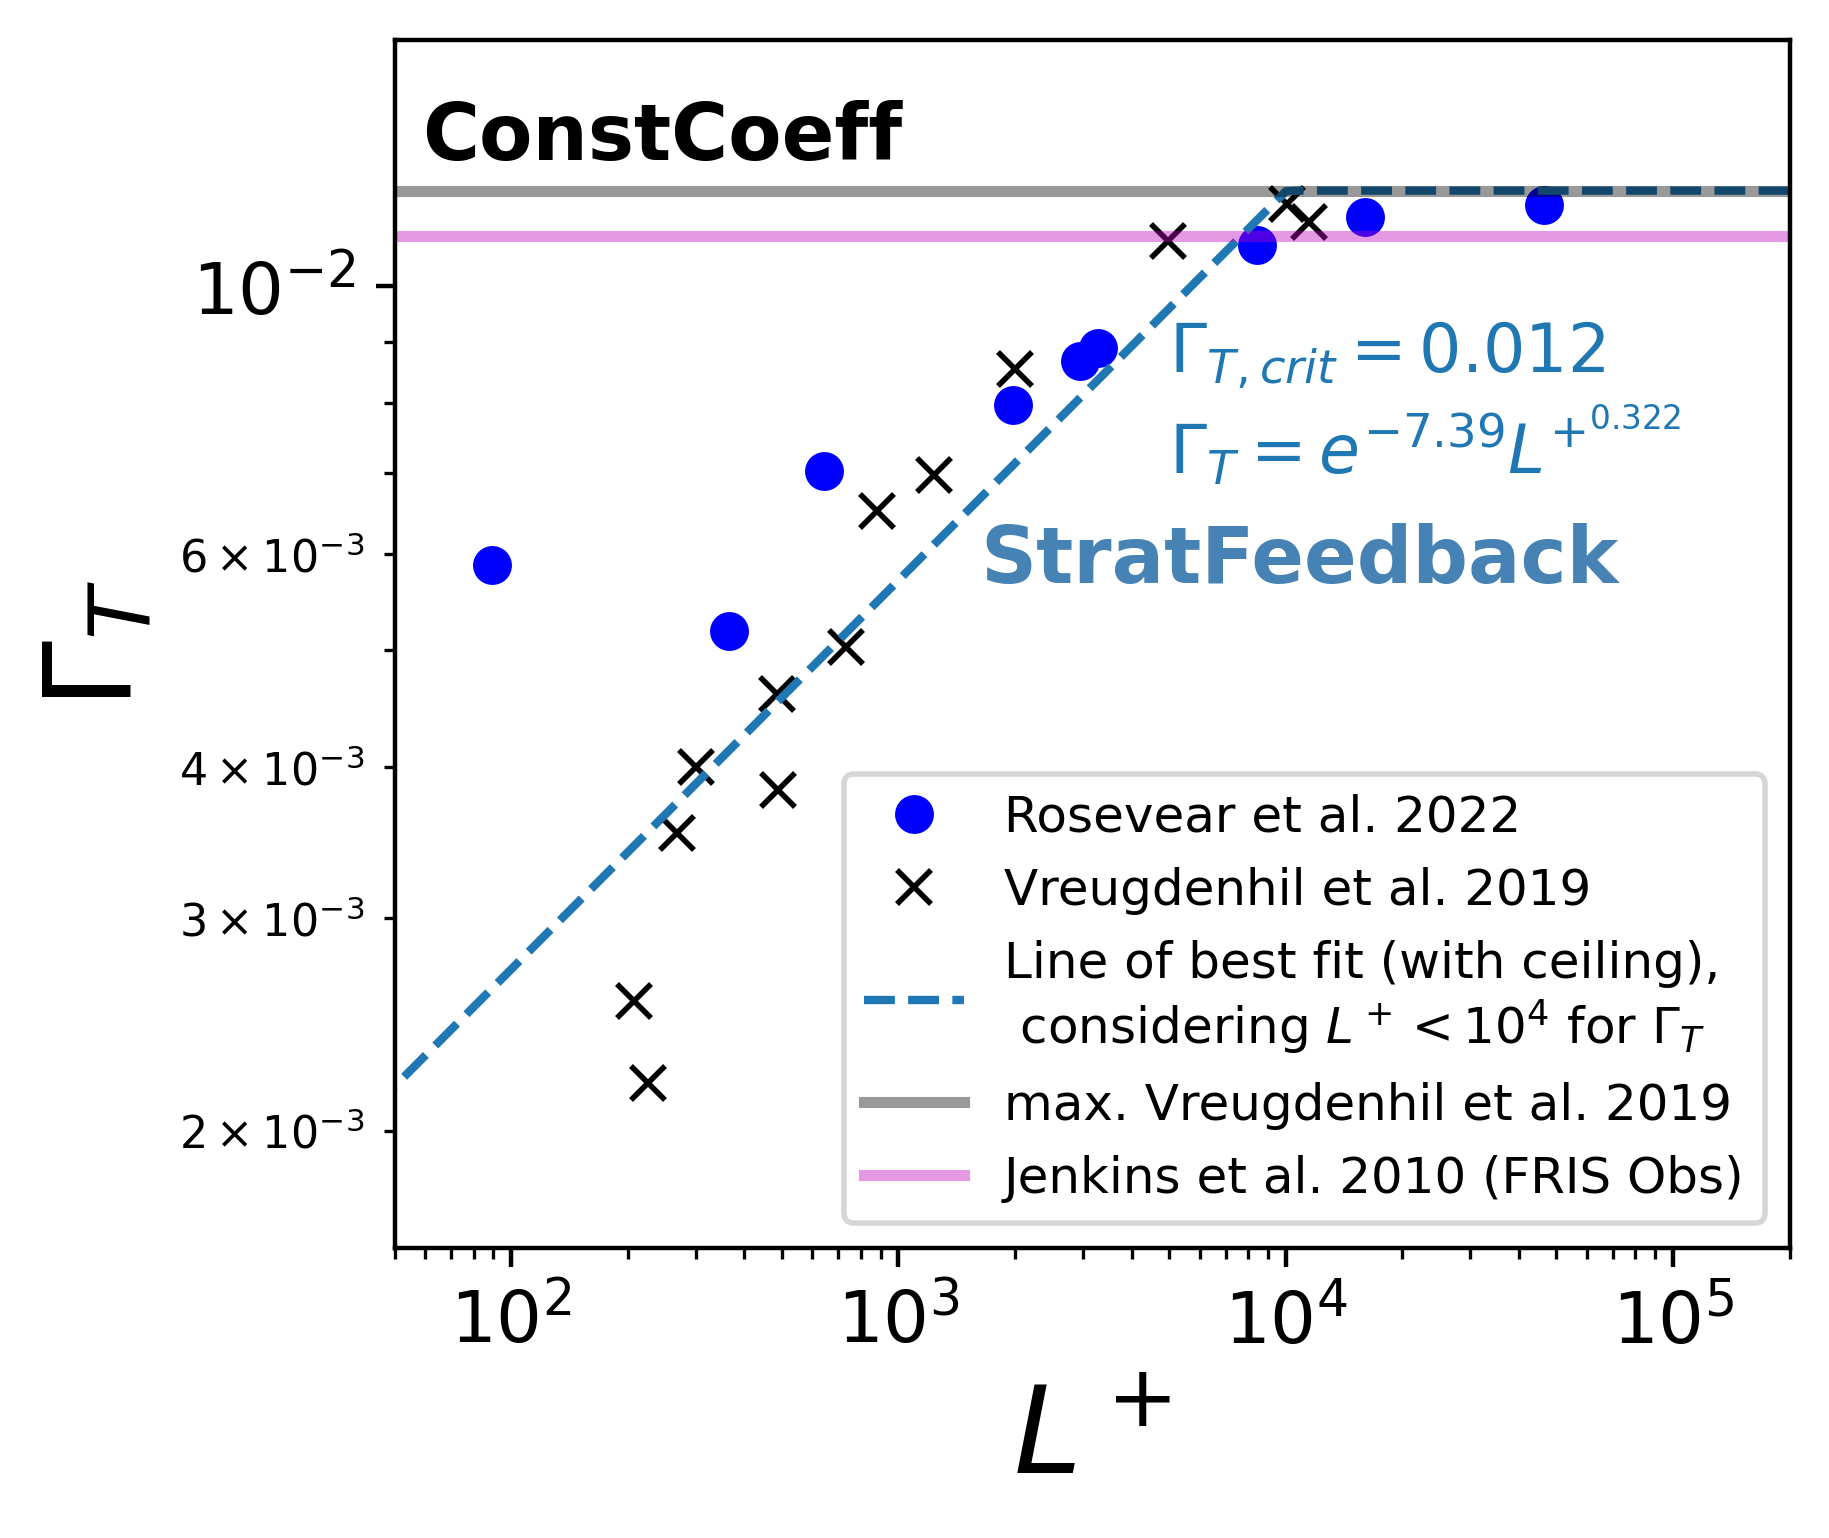

In [10]:
f, ax = plt.subplots(1,figsize = (4.5,4),dpi = 400)
#f.subplots_adjust(wspace=0.5)


L_plus_arr = np.linspace(1,1e6,1000)
# #0.15224053 -9.47443189
# Gamma_T_arr = np.exp(-7.58)*L_plus_arr**0.354
# Gamma_S_arr = np.exp(-9.489)*L_plus_arr**0.155 #np.exp(-9.29)*L_plus_arr**0.122 #

Gamma_T_arr = np.exp(-7.39)*L_plus_arr**0.322
Gamma_S_arr = np.exp(-9.89)*L_plus_arr**0.223

for i in np.arange(len(Gamma_T_arr)):
    Gamma_T_arr[i]=min(Gamma_T_arr[i],0.012) #0.011
    Gamma_S_arr[i]=min(Gamma_S_arr[i],3.9e-4) #3.1e-4


ax.loglog(d1.L_plus, d1.Gamma_T, 'ob', label = 'Rosevear et al. 2022')
ax.loglog(Lp_Vreug, GT_Vreug, 'kx', label = 'Vreugdenhil et al. 2019')
#ax.loglog(L_plus_arr,Gamma_T_arr, '--',label = 'Line of best fit current')
#ax[0].loglog(L_plus_arr,Gamma_T_arr_og_grad, '--',label = 'Line of best fit original grad')
ax.loglog(L_plus_arr,Gamma_T_arr, '--',label = 'Line of best fit (with ceiling), \n considering $L^+<10^4$ for $\Gamma_T$ ')
#ax[0].loglog(L_plus_arr,Gamma_T_arr_shallow, '--',label = 'Line of best fit shallow')
#ax[0].loglog(L_plus_arr,Gamma_T_arr_steep, '--',label = 'Line of best fit steep')
#ax[0].loglog(L_plus_arr,Gamma_T_arr_v2, '--',label = 'Line of best fit L+<1e4')
#ax[0].loglog(L_plus_arr,Gamma_T_arr_MR, '--',label = 'Line of best fit MR')
# ax[0].loglog(Lp_tide_ts[0,:], GT_tide_ts[0,:], 'rd', alpha = 0.1, label = 'tide-ellipse')
# ax[0].loglog(Lp_tide_ts[1,:], GT_tide_ts[1,:], 'gd', alpha = 0.1, label = 'tide-rectilinear')
ax.set(ylabel = r'$\Gamma_T$', xlabel = r'$L^+$',
      ylim = [1.6e-3, 0.016], xlim = [50, 2e5])
ax.set_ylabel(r'$\Gamma_T$',fontsize = 22)
ax.set_xlabel(r'$L^+$',fontsize = 22)

ax.text(5e3,7e-3,'$\Gamma_{T,crit} = 0.012$ \n$\Gamma_T = e^{-7.39} L^{+^{0.322}}$ ',color = 'C0',fontsize = 12)


ax.plot([1,200000],[0.012, 0.012],'-k', linewidth = 2, label = 'max. Vreugdenhil et al. 2019', alpha = 0.4)
#ax[1].plot([1,200000],[0.00039, 0.00039],'-c', linewidth = 2, label = 'max, Vreugdenhil et al 2019', alpha = 0.3)


ax.plot([1,200000],[0.011, 0.011],'-m', linewidth = 2, label = 'Jenkins et al. 2010 (FRIS Obs)', alpha = 0.4)
#ax[1].plot([1,200000],[0.00031, 0.00031],'-m', linewidth = 2, label = 'Jenkins et al. 2010', alpha = 0.3)

#ax[0].plot([20000,20000],[1e-5, 0.1],':k', linewidth = 1)
#ax[1].plot([20000,20000],[1e-5, 0.1],':k', linewidth = 1)
#ax[2].plot([2000,2000],[1e-5, 100],'--k', linewidth = 1)
ax.text(0.02,0.95,'ConstCoeff',horizontalalignment='left', fontweight='bold',
     verticalalignment='top',transform=ax.transAxes, fontsize = 14)
ax.text(0.42,0.6,'StratFeedback',horizontalalignment='left', fontweight='bold',
     verticalalignment='top',transform=ax.transAxes, fontsize = 14,color = 'steelblue')
ax.legend(loc = 'lower right', fontsize = 9)

#f.savefig('transfer_my_data_only.png', bbox_inches='tight',dpi=280, format='png')
plt.tick_params(labelsize=13)



In [22]:
xTo = np.concatenate([d1.L_plus.values,Lp_Vreug], axis = 0)
yTo = np.concatenate([d1.Gamma_T.values,GT_Vreug], axis = 0)

xT = xTo[xTo<1e4]
yT = yTo[xTo<1e4]
print(np.polyfit(np.log(xT), np.log(yT), 1))

xSo = np.concatenate([d1.L_plus.values,Lp_Vreug], axis = 0)
ySo = np.concatenate([d1.Gamma_S.values,GS_Vreug], axis = 0)
xS = xSo[xSo<2e4]
yS = ySo[xSo<2e4]

print(np.polyfit(np.log(xS), np.log(yS), 1))

# coefficients in order of highest power first: y = Ax + B

[ 0.35427943 -7.5849801 ]
[ 0.15224053 -9.47443189]


In [72]:
plt.rcParams.update({'font.size': 12})
plt.rc('xtick', labelsize=9)    # fontsize of the tick labels
plt.rc('ytick', labelsize=9)    # fontsize of the tick labels
plt.rc('legend', fontsize=10)    # legend fontsize


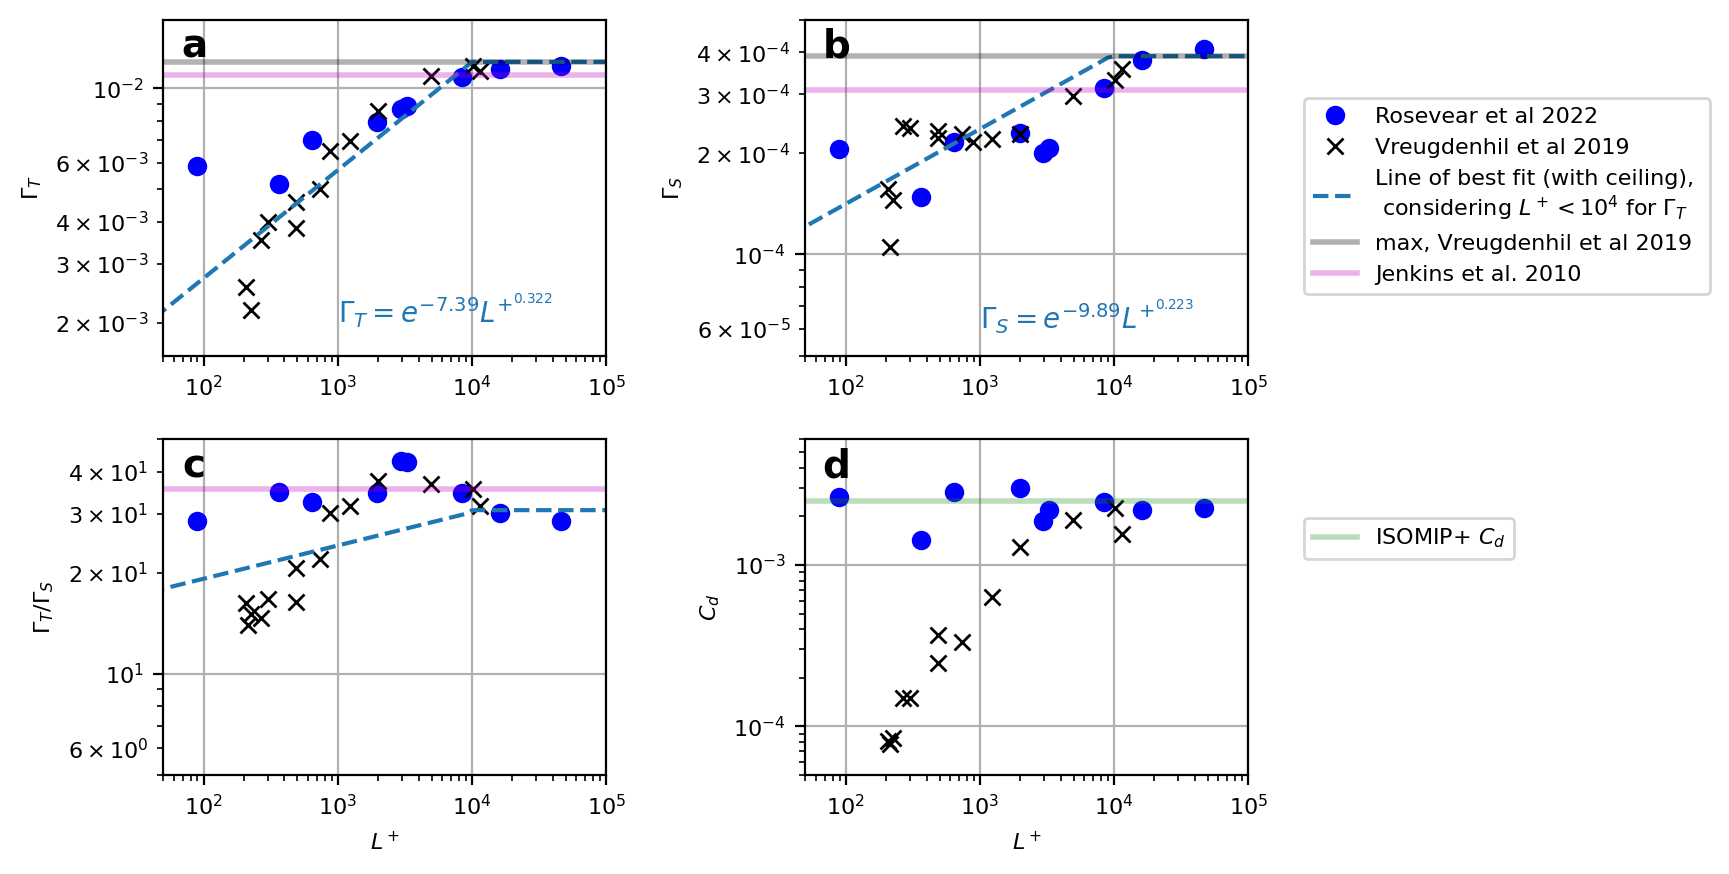

In [11]:
f, ax = plt.subplots(2,2,figsize = (7,5),dpi = 200)
f.subplots_adjust(wspace=0.5)


#0.32220281 -7.39041184]
#[ 0.2226009  -9.89970135

L_plus_arr = np.linspace(1,1e6,1000)
# #0.15224053 -9.47443189
# Gamma_T_arr = np.exp(-7.58)*L_plus_arr**0.354
# Gamma_S_arr = np.exp(-9.489)*L_plus_arr**0.155 #np.exp(-9.29)*L_plus_arr**0.122 #

Gamma_T_arr = np.exp(-7.39)*L_plus_arr**0.322
Gamma_S_arr = np.exp(-9.89)*L_plus_arr**0.223

for i in np.arange(len(Gamma_T_arr)):
    Gamma_T_arr[i]=min(Gamma_T_arr[i],0.012) #0.011
    Gamma_S_arr[i]=min(Gamma_S_arr[i],3.9e-4) #3.1e-4


ax[0,0].plot(d1.L_plus, d1.Gamma_T, 'ob', label = 'Rosevear et al. 2022')
ax[0,0].plot(Lp_Vreug, GT_Vreug, 'kx', label = 'Vreugdenhil et al. 2019')
#ax[0].loglog(L_plus_arr,Gamma_T_arr, '--',label = 'Line of best fit')
ax[0,0].loglog(L_plus_arr,Gamma_T_arr, '--',label = 'Line of best fit (with ceiling), \n considering $L^+<10^4$ for $\Gamma_T$ ')
#ax[0].loglog(L_plus_arr,Gamma_T_arr_v2, '--',label = 'Line of best fit L+<1e4')
#ax[0].loglog(L_plus_arr,Gamma_T_arr_MR, '--',label = 'Line of best fit MR')
# ax[0].loglog(Lp_tide_ts[0,:], GT_tide_ts[0,:], 'rd', alpha = 0.1, label = 'tide-ellipse')
# ax[0].loglog(Lp_tide_ts[1,:], GT_tide_ts[1,:], 'gd', alpha = 0.1, label = 'tide-rectilinear')
ax[0,0].set(ylabel = r'$\Gamma_T$', xlabel = '',
      ylim = [1.6e-3, 0.016], xlim = [50, 1e5])
ax[0,0].text(1e3,2e-3,'$\Gamma_T = e^{-7.39} L^{+^{0.322}}$',color = 'C0',fontsize = 10)

ax[0,1].plot(d1.L_plus, d1.Gamma_S, 'ob', label = 'Rosevear et al 2022')
ax[0,1].plot(Lp_Vreug, GS_Vreug, 'kx', label = 'Vreugdenhil et al 2019')
# ax[1].loglog(Lp_tide_ts[0,:], GS_tide_ts[0,:], 'rd', alpha = 0.1)
# ax[1].loglog(Lp_tide_ts[1,:], GS_tide_ts[1,:], 'gd', alpha = 0.1)
#ax[1].loglog(L_plus_arr,Gamma_S_arr, '--',label = 'Line of best fit')
ax[0,1].loglog(L_plus_arr,Gamma_S_arr, '--',label = 'Line of best fit (with ceiling), \n considering $L^+<10^4$ for $\Gamma_T$ ')
#ax[1].loglog(L_plus_arr,Gamma_S_arr_v2, '--',label = 'Line of best fit L+<1e4')
#ax[1].loglog(L_plus_arr,Gamma_S_arr_MR, '--',label = 'Line of best fit MR')

ax[0,1].set(ylabel = r'$\Gamma_S$', xlabel = '',
      ylim = [5e-5, 0.0005], xlim = [50, 1e5])
ax[0,1].text(1e3,6e-5,'$\Gamma_S = e^{-9.89} L^{+^{0.223}}$',color = 'C0',fontsize = 10)

ax[1,0].loglog(d1.L_plus, d1.Gamma_T/d1.Gamma_S, 'ob', label = 'Rosevear et al 2022')
ax[1,0].loglog(Lp_Vreug, GT_Vreug/GS_Vreug, 'xk', label = 'Vreugdenhil et al 2019')
# # ax[2].loglog(Lp_tide_ts[0,:], GT_tide_ts[0,:]/GS_tide_ts[0,:], 'rd', alpha = 0.1)
# # ax[2].loglog(Lp_tide_ts[1,:], GT_tide_ts[1,:]/GS_tide_ts[1,:], 'gd', alpha = 0.1)
ax[1,0].set(ylabel = r'$\Gamma_T/\Gamma_S$', xlabel = r'$L^+$',
      ylim = [5, 50], xlim = [50, 1e5])

ax[1,1].loglog(d1.L_plus, d1.Cd, 'ob')
ax[1,1].loglog(Lp_Vreug, Cd_Vreug, 'xk')
# # ax[3].loglog(Lp_tide_ts[0,:], Cd_tide_ts[0,:], 'rd', alpha = 0.1)
# # ax[3].loglog(Lp_tide_ts[1,:], Cd_tide_ts[1,:], 'gd', alpha = 0.1)
ax[1,1].set(ylabel = r'$C_d$', xlabel = r'$L^+$',
      ylim = [5e-5, 6e-3], xlim = [50, 1e5])

#ax[0].plot([2000,2000],[1e-5, 0.1],':k', linewidth = 1)
#ax[1].plot([2000,2000],[1e-5, 0.1],':k', linewidth = 1)

ax[0,0].plot([1,200000],[0.012, 0.012],'-k', linewidth = 2, label = 'max, Vreugdenhil et al. 2019', alpha = 0.3)
ax[0,1].plot([1,200000],[0.00039, 0.00039],'-k', linewidth = 2, label = 'max, Vreugdenhil et al 2019', alpha = 0.3)

ax[0,0].plot([1,200000],[0.011, 0.011],'-m', linewidth = 2, label = 'Jenkins et al. 2010', alpha = 0.3)
ax[0,1].plot([1,200000],[0.00031, 0.00031],'-m', linewidth = 2, label = 'Jenkins et al. 2010', alpha = 0.3)
ax[1,0].plot([1,200000],[0.011/0.00031,0.011/0.00031],'-m', linewidth = 2, label = 'Jenkins et al. 2010', alpha = 0.3)

ax[1,0].loglog(L_plus_arr,Gamma_T_arr/Gamma_S_arr, '--',label = 'Line of best fit for $L^+<10^4$ (with ceiling)')

ax[1,1].plot([1,200000],[0.0025,0.0025],'forestgreen', linewidth = 2, label = 'ISOMIP+ $C_d$', alpha = 0.3)

#ax[0].plot([20000,20000],[1e-5, 0.1],':k', linewidth = 1)
#ax[1].plot([20000,20000],[1e-5, 0.1],':k', linewidth = 1)
#ax[2].plot([2000,2000],[1e-5, 100],'--k', linewidth = 1)

ax[0,1].legend(bbox_to_anchor = (1.1,0.8),loc = 'upper left')
ax[1,1].legend(bbox_to_anchor = (1.1,0.8),loc = 'upper left')

#f.savefig('transfer_my_data_only.png', bbox_inches='tight',dpi=280, format='png')

ax[0,0].grid()
ax[0,1].grid()
ax[1,0].grid()
ax[1,1].grid()

ax[0,0].text(0.07,0.92,'a',horizontalalignment='center', fontweight='bold',
     verticalalignment='center',transform=ax[0,0].transAxes, fontsize = 14)
ax[0,1].text(0.07,0.92,'b',horizontalalignment='center', fontweight='bold',
     verticalalignment='center',transform=ax[0,1].transAxes, fontsize = 14)
ax[1,0].text(0.07,0.92,'c',horizontalalignment='center', fontweight='bold',
     verticalalignment='center',transform=ax[1,0].transAxes, fontsize = 14)
ax[1,1].text(0.07,0.92,'d',horizontalalignment='center', fontweight='bold',
     verticalalignment='center',transform=ax[1,1].transAxes, fontsize = 14)

f.subplots_adjust(hspace = 0.25,wspace = 0.45)

Add Max and Min

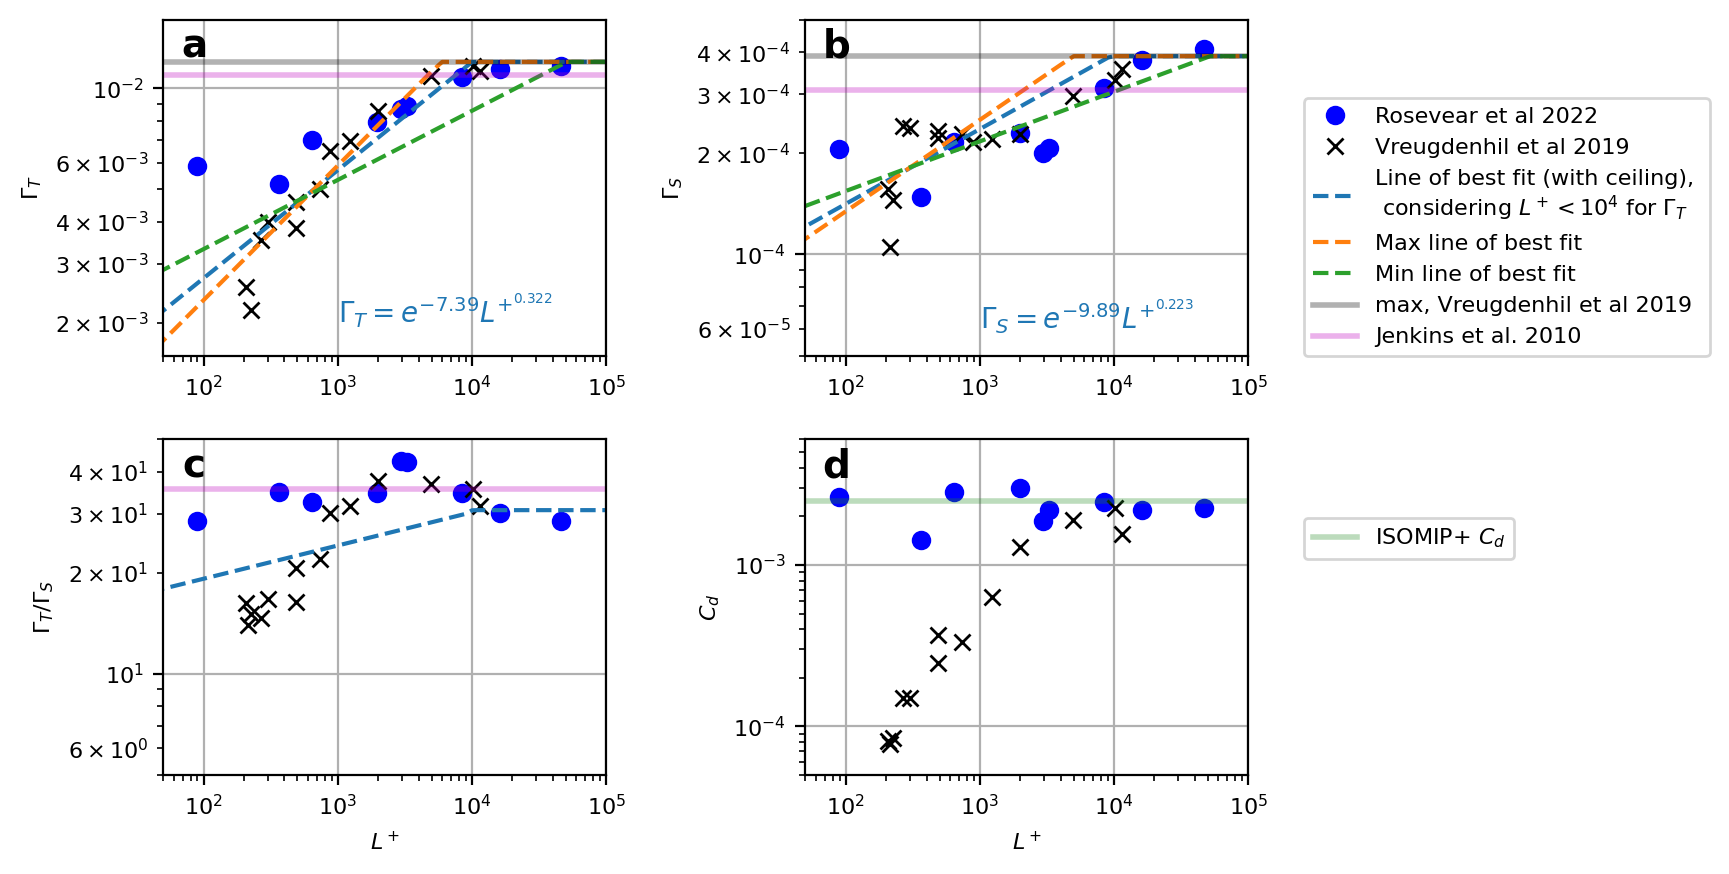

In [12]:
f, ax = plt.subplots(2,2,figsize = (7,5),dpi = 200)
f.subplots_adjust(wspace=0.5)

#best
#0.32220281 -7.39041184]
#[ 0.2226009  -9.89970135

# max
# 0.40866537790650465 -7.903610262369218 #T
# 0.27278338456978873 -10.172933049589611 #S
# min
# 0.20640069708387848 -6.655960835873457 #T
# 0.14845278583586022 -9.45560731807653 #S

L_plus_arr = np.linspace(1,1e6,1000)
# #0.15224053 -9.47443189
# Gamma_T_arr = np.exp(-7.58)*L_plus_arr**0.354
# Gamma_S_arr = np.exp(-9.489)*L_plus_arr**0.155 #np.exp(-9.29)*L_plus_arr**0.122 #

Gamma_T_arr = np.exp(-7.39)*L_plus_arr**0.322
Gamma_S_arr = np.exp(-9.89)*L_plus_arr**0.223
for i in np.arange(len(Gamma_T_arr)):
    Gamma_T_arr[i]=min(Gamma_T_arr[i],0.012) #0.011
    Gamma_S_arr[i]=min(Gamma_S_arr[i],3.9e-4) #3.1e-4


## max and min
  
Gamma_T_arr_max = np.exp(-7.904)*L_plus_arr**0.401
Gamma_S_arr_max = np.exp(-10.17)*L_plus_arr**0.2727
for i in np.arange(len(Gamma_T_arr)):
    Gamma_T_arr_max[i]=min(Gamma_T_arr_max[i],0.012) #0.011
    Gamma_S_arr_max[i]=min(Gamma_S_arr_max[i],3.9e-4) #3.1e-4

Gamma_T_arr_min = np.exp(-6.656)*L_plus_arr**0.206
Gamma_S_arr_min = np.exp(-9.456)*L_plus_arr**0.148
for i in np.arange(len(Gamma_T_arr)):
    Gamma_T_arr_min[i]=min(Gamma_T_arr_min[i],0.012) #0.011
    Gamma_S_arr_min[i]=min(Gamma_S_arr_min[i],3.9e-4) #3.1e-4
 
    
ax[0,0].plot(d1.L_plus, d1.Gamma_T, 'ob', label = 'Rosevear et al. 2022')
ax[0,0].plot(Lp_Vreug, GT_Vreug, 'kx', label = 'Vreugdenhil et al. 2019')
#ax[0].loglog(L_plus_arr,Gamma_T_arr, '--',label = 'Line of best fit')
ax[0,0].loglog(L_plus_arr,Gamma_T_arr, '--',label = 'Line of best fit (with ceiling), \n considering $L^+<10^4$ for $\Gamma_T$ ')
ax[0,0].loglog(L_plus_arr,Gamma_T_arr_max, '--',label = 'Max line of best fit')
ax[0,0].loglog(L_plus_arr,Gamma_T_arr_min, '--',label = 'Min line of best fit')
#ax[0].loglog(L_plus_arr,Gamma_T_arr_v2, '--',label = 'Line of best fit L+<1e4')
#ax[0].loglog(L_plus_arr,Gamma_T_arr_MR, '--',label = 'Line of best fit MR')
# ax[0].loglog(Lp_tide_ts[0,:], GT_tide_ts[0,:], 'rd', alpha = 0.1, label = 'tide-ellipse')
# ax[0].loglog(Lp_tide_ts[1,:], GT_tide_ts[1,:], 'gd', alpha = 0.1, label = 'tide-rectilinear')
ax[0,0].set(ylabel = r'$\Gamma_T$', xlabel = '',
      ylim = [1.6e-3, 0.016], xlim = [50, 1e5])
ax[0,0].text(1e3,2e-3,'$\Gamma_T = e^{-7.39} L^{+^{0.322}}$',color = 'C0',fontsize = 10)

ax[0,1].plot(d1.L_plus, d1.Gamma_S, 'ob', label = 'Rosevear et al 2022')
ax[0,1].plot(Lp_Vreug, GS_Vreug, 'kx', label = 'Vreugdenhil et al 2019')
# ax[1].loglog(Lp_tide_ts[0,:], GS_tide_ts[0,:], 'rd', alpha = 0.1)
# ax[1].loglog(Lp_tide_ts[1,:], GS_tide_ts[1,:], 'gd', alpha = 0.1)
#ax[1].loglog(L_plus_arr,Gamma_S_arr, '--',label = 'Line of best fit')
ax[0,1].loglog(L_plus_arr,Gamma_S_arr, '--',label = 'Line of best fit (with ceiling), \n considering $L^+<10^4$ for $\Gamma_T$ ')
ax[0,1].loglog(L_plus_arr,Gamma_S_arr_max, '--',label = 'Max line of best fit')
ax[0,1].loglog(L_plus_arr,Gamma_S_arr_min, '--',label = 'Min line of best fit')
#ax[1].loglog(L_plus_arr,Gamma_S_arr_v2, '--',label = 'Line of best fit L+<1e4')
#ax[1].loglog(L_plus_arr,Gamma_S_arr_MR, '--',label = 'Line of best fit MR')

ax[0,1].set(ylabel = r'$\Gamma_S$', xlabel = '',
      ylim = [5e-5, 0.0005], xlim = [50, 1e5])
ax[0,1].text(1e3,6e-5,'$\Gamma_S = e^{-9.89} L^{+^{0.223}}$',color = 'C0',fontsize = 10)

ax[1,0].loglog(d1.L_plus, d1.Gamma_T/d1.Gamma_S, 'ob', label = 'Rosevear et al 2022')
ax[1,0].loglog(Lp_Vreug, GT_Vreug/GS_Vreug, 'xk', label = 'Vreugdenhil et al 2019')
# # ax[2].loglog(Lp_tide_ts[0,:], GT_tide_ts[0,:]/GS_tide_ts[0,:], 'rd', alpha = 0.1)
# # ax[2].loglog(Lp_tide_ts[1,:], GT_tide_ts[1,:]/GS_tide_ts[1,:], 'gd', alpha = 0.1)
ax[1,0].set(ylabel = r'$\Gamma_T/\Gamma_S$', xlabel = r'$L^+$',
      ylim = [5, 50], xlim = [50, 1e5])

ax[1,1].loglog(d1.L_plus, d1.Cd, 'ob')
ax[1,1].loglog(Lp_Vreug, Cd_Vreug, 'xk')
# # ax[3].loglog(Lp_tide_ts[0,:], Cd_tide_ts[0,:], 'rd', alpha = 0.1)
# # ax[3].loglog(Lp_tide_ts[1,:], Cd_tide_ts[1,:], 'gd', alpha = 0.1)
ax[1,1].set(ylabel = r'$C_d$', xlabel = r'$L^+$',
      ylim = [5e-5, 6e-3], xlim = [50, 1e5])

#ax[0].plot([2000,2000],[1e-5, 0.1],':k', linewidth = 1)
#ax[1].plot([2000,2000],[1e-5, 0.1],':k', linewidth = 1)

ax[0,0].plot([1,200000],[0.012, 0.012],'-k', linewidth = 2, label = 'max, Vreugdenhil et al. 2019', alpha = 0.3)
ax[0,1].plot([1,200000],[0.00039, 0.00039],'-k', linewidth = 2, label = 'max, Vreugdenhil et al 2019', alpha = 0.3)

ax[0,0].plot([1,200000],[0.011, 0.011],'-m', linewidth = 2, label = 'Jenkins et al. 2010', alpha = 0.3)
ax[0,1].plot([1,200000],[0.00031, 0.00031],'-m', linewidth = 2, label = 'Jenkins et al. 2010', alpha = 0.3)
ax[1,0].plot([1,200000],[0.011/0.00031,0.011/0.00031],'-m', linewidth = 2, label = 'Jenkins et al. 2010', alpha = 0.3)

ax[1,0].loglog(L_plus_arr,Gamma_T_arr/Gamma_S_arr, '--',label = 'Line of best fit for $L^+<10^4$ (with ceiling)')

ax[1,1].plot([1,200000],[0.0025,0.0025],'forestgreen', linewidth = 2, label = 'ISOMIP+ $C_d$', alpha = 0.3)

#ax[0].plot([20000,20000],[1e-5, 0.1],':k', linewidth = 1)
#ax[1].plot([20000,20000],[1e-5, 0.1],':k', linewidth = 1)
#ax[2].plot([2000,2000],[1e-5, 100],'--k', linewidth = 1)

ax[0,1].legend(bbox_to_anchor = (1.1,0.8),loc = 'upper left')
ax[1,1].legend(bbox_to_anchor = (1.1,0.8),loc = 'upper left')

#f.savefig('transfer_my_data_only.png', bbox_inches='tight',dpi=280, format='png')

ax[0,0].grid()
ax[0,1].grid()
ax[1,0].grid()
ax[1,1].grid()

ax[0,0].text(0.07,0.92,'a',horizontalalignment='center', fontweight='bold',
     verticalalignment='center',transform=ax[0,0].transAxes, fontsize = 14)
ax[0,1].text(0.07,0.92,'b',horizontalalignment='center', fontweight='bold',
     verticalalignment='center',transform=ax[0,1].transAxes, fontsize = 14)
ax[1,0].text(0.07,0.92,'c',horizontalalignment='center', fontweight='bold',
     verticalalignment='center',transform=ax[1,0].transAxes, fontsize = 14)
ax[1,1].text(0.07,0.92,'d',horizontalalignment='center', fontweight='bold',
     verticalalignment='center',transform=ax[1,1].transAxes, fontsize = 14)

f.subplots_adjust(hspace = 0.25,wspace = 0.45)